In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1 - Setup

## 1.1. Packages

In [ ]:
!pip install --upgrade torch torchvision deepface face_recognition --quiet

In [ ]:
!pip install mtcnn facenet_pytorch -q

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from pathlib import Path

import random
from collections import defaultdict

import zipfile

import albumentations as A
#from albumentations.augmentations.transforms import GaussianNoise

from mtcnn import MTCNN
import cv2

from tqdm import tqdm

from PIL import Image
import torch

from facenet_pytorch import InceptionResnetV1
from sklearn.metrics.pairwise import cosine_similarity

import shutil
from sklearn.model_selection import train_test_split

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import itertools

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-04-21 03:36:35.295844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745206595.318281     154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745206595.325178     154 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1.2. Data Preparation

In [2]:
output_folder = '/kaggle/input/dataset-pcd/full version/'

In [3]:
path = '/kaggle/input/dataset-pcd/full version/'
base_path = '/kaggle/working/'

# 2 - Preprocessing

## 2.1. MTCNN Face Cropping

I0000 00:00:1745206610.232993     154 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745206610.233869     154 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


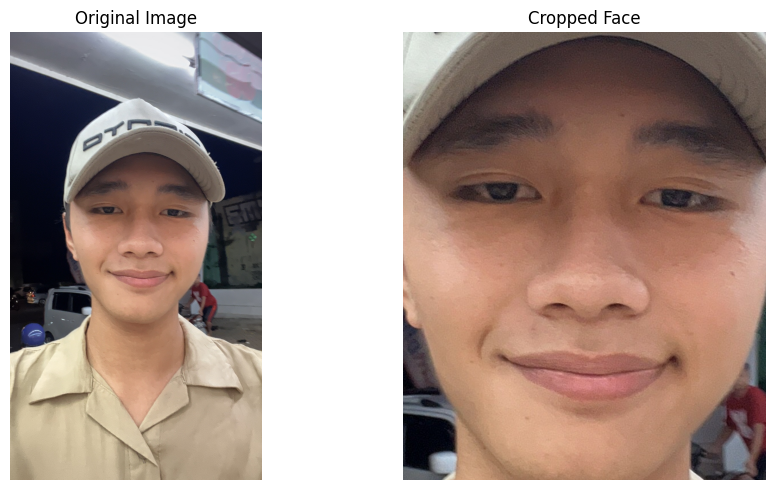

In [4]:
img = cv2.imread(f"{path}/Abay_Dekat.jpeg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector = MTCNN()
faces = detector.detect_faces(img_rgb)

if faces:
    x, y, w, h = faces[0]['box']
    face_crop = img_rgb[y:y+h, x:x+w]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(face_crop)
    axes[1].set_title("Cropped Face")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No face detected.")

In [5]:
output_folder = os.path.join(base_path, 'cropped_mtcnn')
os.makedirs(output_folder, exist_ok=True)

detector = MTCNN()

image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for filename in tqdm(image_files, desc="Processing Images"):
    img_path = os.path.join(path, filename)
    img = cv2.imread(img_path)
    if img is None:
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)

    for i, face in enumerate(faces):
        x, y, w, h = face['box']
        face_crop = img[y:y+h, x:x+w]
        save_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_face{i+1}.jpg")
        cv2.imwrite(save_path, face_crop)

Processing Images: 100%|██████████| 81/81 [16:12<00:00, 12.01s/it]


In [6]:
for filename in os.listdir(output_folder):
    if not filename.endswith('_face1.jpg'):
        file_path = os.path.join(output_folder, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

In [7]:
unique_name = []
for filename in os.listdir(output_folder):
  unique_name.append(filename.split('_')[0])

unique_name = set(unique_name)
unique_name, len(unique_name)

({'Abay',
  'Ahmad',
  'Akbar',
  'Ambon',
  'Azwa',
  'Faris',
  'Humsans',
  'Ibrahim',
  'Mutiah',
  'Rafka',
  'Rara',
  'Rizal',
  'Rizky',
  'Saskia',
  'Tian'},
 15)

## 2.2. Data Splitting

In [8]:
pairs = {
  'Abay': 'batak',
  'Ahmad': 'jawa',
  'Akbar': 'jawa',
  'Ambon': 'jawa',
  'Azwa': 'batak',
  'Faris': 'jawa',
  'Humsans': 'sunda',
  'Ibrahim': 'sunda',
  'Mutiah': 'sunda',
  'Rafka': 'sunda',
  'Rara': 'batak',
  'Rizal': 'jawa',
  'Rizky': 'sunda',
  'Saskia': 'batak',
  'Tian': 'batak',
  }

In [9]:
names = list(pairs.keys())
labels = list(pairs.values())

X_train, X_temp, y_train, y_temp = train_test_split(
    names, labels, test_size=0.4, stratify=labels, random_state=1
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=35
)

train_set = {name: pairs[name] for name in X_train}
val_set = {name: pairs[name] for name in X_val}
test_set = {name: pairs[name] for name in X_test}

print("Train:", train_set)
print("\nValidation:", val_set)
print("\nTest:", test_set)

Train: {'Ahmad': 'jawa', 'Ibrahim': 'sunda', 'Mutiah': 'sunda', 'Rara': 'batak', 'Tian': 'batak', 'Azwa': 'batak', 'Ambon': 'jawa', 'Rizal': 'jawa', 'Rafka': 'sunda'}

Validation: {'Rizky': 'sunda', 'Saskia': 'batak', 'Akbar': 'jawa'}

Test: {'Humsans': 'sunda', 'Faris': 'jawa', 'Abay': 'batak'}


## 2.3. Image Foldering

In [10]:
output_folder

'/kaggle/working/cropped_mtcnn'

In [11]:
splits = ['Train', 'Val', 'Test']
labels = ['jawa', 'batak', 'sunda']

for split in splits:
    for label in labels:
        os.makedirs(os.path.join(base_path, split, label.capitalize()), exist_ok=True)

all_sets = {
    'Train': train_set,
    'Val': val_set,
    'Test': test_set
}

for split, name_label_dict in all_sets.items():
    for name, label in name_label_dict.items():
        for file in os.listdir(output_folder):
            if file.startswith(name.capitalize()):
                src_path = os.path.join(output_folder, file)
                dst_path = os.path.join(base_path, split, label.capitalize(), file)
                shutil.copy(src_path, dst_path)

# 3 - Image Similarity

## 3.1. Image Pairs Preparation

In [12]:
image_folder = output_folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

pairs = list(itertools.combinations(image_files, 2))

data = []
for img1, img2 in pairs:
    name1 = img1.split('_')[0].lower()
    name2 = img2.split('_')[0].lower()
    actual = "Yes" if name1 == name2 else "No"
    data.append({'img1': img1, 'img2': img2, 'actual': actual})

df_pairs = pd.DataFrame(data)
df_pairs.sample(5)

,img1,img2,actual
2677,Humsans_Senyum_face1.jpg,Rara_Dekat_face1.jpg,No
2230,Rafka_Dekat_face1.jpg,Faris_Outdoor_face1.jpg,No
1057,Faris_Indoor_face1.jpg,Azwa_Jauh_face1.jpg,No
493,Akbar_Senyum_face1.jpg,Saskia_Senyum_face1.jpg,No
2147,Rafka_Outdoor_face1.jpg,Faris_Outdoor_face1.jpg,No


In [13]:
df_pairs.shape

(3081, 3)

## 3.2. Model Initialization

In [14]:
sim_model = InceptionResnetV1(pretrained='vggface2').eval()

def preprocess_face(face_img):
    face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(face_rgb, (160, 160))
    tensor = torch.tensor(resized).permute(2, 0, 1).float() / 255.0
    return tensor.unsqueeze(0)

def calculate_similarity(image1, image2):
    preprocessed1 = preprocess_face(image1)
    preprocessed2 = preprocess_face(image2)

    with torch.no_grad():
        embedding1 = sim_model(preprocessed1)
        embedding2 = sim_model(preprocessed2)

    sim = cosine_similarity(embedding1.numpy(), embedding2.numpy())[0][0]
    return sim, image1, image2

  0%|          | 0.00/107M [00:00<?, ?B/s]

## 3.2. Similarity Inferencing

In [15]:
THRESH = 0.5

In [ ]:
sims = []
for _, row in tqdm(df_pairs.iterrows(), total=len(df_pairs)):
    path1 = os.path.join(image_folder, row['img1'])
    path2 = os.path.join(image_folder, row['img2'])

    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    sim = calculate_similarity(img1, img2)
    sims.append(sim)

df_pairs['pred_proba'] = sims

In [23]:
df_pairs['proba'] = [(val[0] + 1) / 2 for val in df_pairs['pred_proba']]
df_pairs['pred'] = df_pairs['proba'].apply(
    lambda x: "Yes" if x is not None and x >= THRESH else "No"
)

df_pairs.sample(5)

,img1,img2,actual,pred_proba,proba,pred
1291,Rafka_Jauh_face1.jpg,Humsans_Serius_face1.jpg,No,"(0.26779822, [[[24 19 20], [22 17 18], [21 16 ...",0.633899,Yes
965,Azwa_Outdoor_face1.jpg,Mutiah_Indoor_face1.jpg,No,"(0.22431007, [[[46 39 42], [46 39 42], [46 39 ...",0.612155,Yes
1549,Rizal_Jauh_face1.jpg,Rizal_Serius_face1.jpg,Yes,"(0.7705374, [[[168 177 180], [169 178 181], [1...",0.885269,Yes
765,Saskia_Outdoor_face1.jpg,Akbar_Serius_face1.jpg,No,"(0.19384518, [[[17 23 36], [24 30 43], [21 28 ...",0.596923,Yes
2494,Rara_Serius_face1.jpg,Rara_Dekat_face1.jpg,Yes,"(0.7359315, [[[235 239 240], [236 240 241], [2...",0.867966,Yes


## 3.3. Similarity Evaluation

In [24]:
df_pairs.to_excel('Similarity Inference Result.xlsx', index=False)

In [30]:
df_pairs.groupby('actual')['pred'].value_counts()

actual  pred
No      Yes     2616
        No       279
Yes     Yes      186
Name: count, dtype: int64

In [26]:
y_true = df_pairs['actual'].map({'Yes': 1, 'No': 0})
y_pred = df_pairs['pred'].map({'Yes': 1, 'No': 0})
y_proba = df_pairs['proba']

In [27]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 279 2616]
 [   0  186]]


In [28]:
report = classification_report(y_true, y_pred, target_names=['No', 'Yes'])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

          No       1.00      0.10      0.18      2895
         Yes       0.07      1.00      0.12       186

    accuracy                           0.15      3081
   macro avg       0.53      0.55      0.15      3081
weighted avg       0.94      0.15      0.17      3081



In [31]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9668


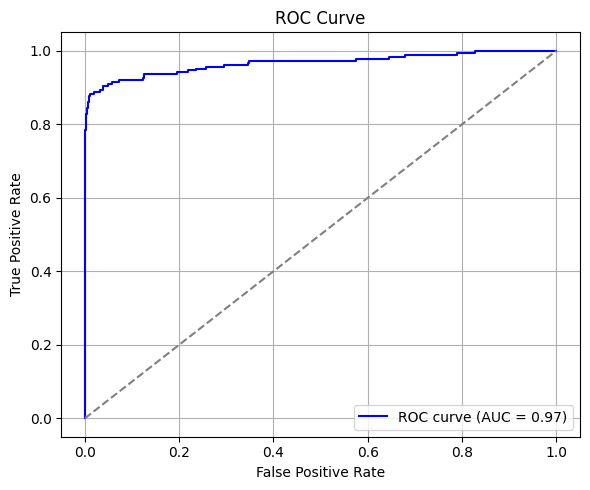

In [32]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

TAR = tp / (tp + fn) if (tp + fn) != 0 else 0 
FAR = fp / (fp + tn) if (fp + tn) != 0 else 0 
FRR = fn / (tp + fn) if (tp + fn) != 0 else 0 

fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

eer_threshold_idx = np.nanargmin(np.abs(fpr - (1 - tpr)))
eer = (fpr[eer_threshold_idx] + (1 - tpr[eer_threshold_idx])) / 2

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"TAR (True Acceptance Rate): {TAR:.4f}")
print(f"FAR (False Acceptance Rate): {FAR:.4f}")
print(f"FRR (False Rejection Rate): {FRR:.4f}")
print(f"EER (Equal Error Rate): {eer:.4f}")
print(f"AUC (Area Under Curve): {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

TAR (True Acceptance Rate): 1.0000
FAR (False Acceptance Rate): 0.9036
FRR (False Rejection Rate): 0.0000
EER (Equal Error Rate): 0.0792
AUC (Area Under Curve): 0.9668
Precision: 0.0664
Recall: 1.0000
F1 Score: 0.1245


## 3.4. Post-Inferencing Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

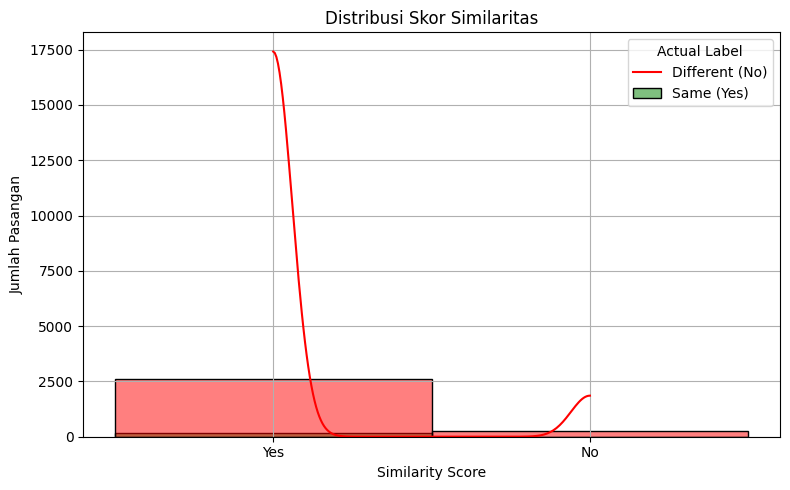

In [34]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_pairs, x='pred', hue='actual', kde=True, bins=50, palette=['red', 'green'])
plt.title('Distribusi Skor Similaritas')
plt.xlabel('Similarity Score')
plt.ylabel('Jumlah Pasangan')
plt.legend(title='Actual Label', labels=['Different (No)', 'Same (Yes)'])
plt.grid(True)
plt.tight_layout()
plt.show()

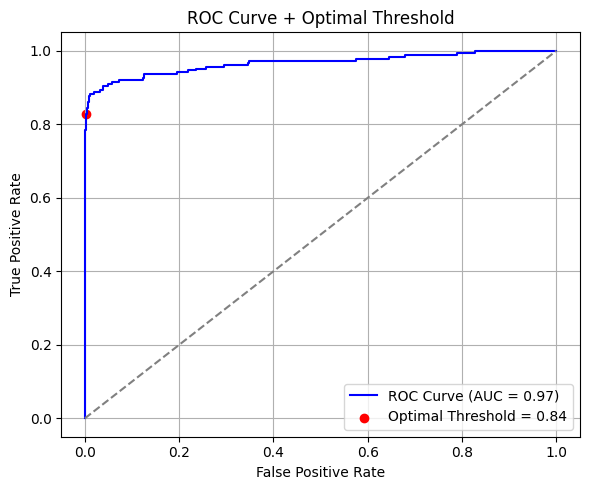

In [35]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

f1_scores = [f1_score(y_true, y_proba >= t) for t in thresholds]
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve + Optimal Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
thresh = optimal_threshold
print(thresh)

0.8362965285778046


In [38]:
df_pairs.sample(4)

,img1,img2,actual,pred_proba,proba,pred
284,Faris_Jauh_face1.jpg,Ahmad_Senyum_face1.jpg,No,"(0.40605873, [[[18 20 20], [21 23 23], [23 25 ...",0.703029,Yes
1399,Rara_Outdoor_face1.jpg,Humsans_Senyum_face1.jpg,No,"(0.067272514, [[[77 63 81], [103 89 107], [82...",0.533636,Yes
941,Azwa_Outdoor_face1.jpg,Tian_Outdoor_face1.jpg,No,"(0.2744699, [[[46 39 42], [46 39 42], [46 39 4...",0.637235,Yes
304,Faris_Jauh_face1.jpg,Rizal_Dekat_face1.jpg,No,"(0.38989538, [[[18 20 20], [21 23 23], [23 25 ...",0.694948,Yes


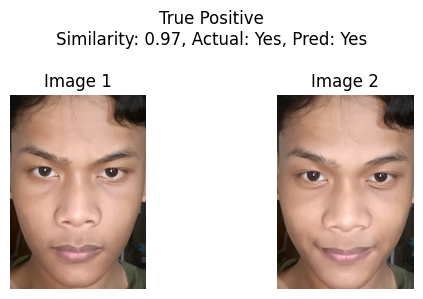

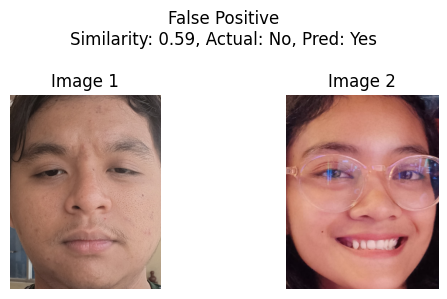

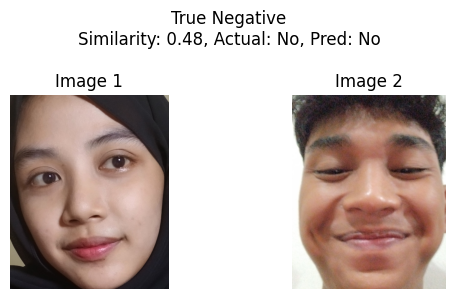

In [47]:
def get_example(df, condition):
    row = df[condition].sample(1).iloc[0]
    img1 = cv2.imread(os.path.join(image_folder, row['img1']))
    img2 = cv2.imread(os.path.join(image_folder, row['img2']))
    return img1, img2, row

def show_side_by_side(img1, img2, title):
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Image 1')
    axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Image 2')
    for ax in axs: ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

tp = (df_pairs['actual'] == 'Yes') & (df_pairs['pred'] == 'Yes')
fp = (df_pairs['actual'] == 'No') & (df_pairs['pred'] == 'Yes')
fn = (df_pairs['actual'] == 'Yes') & (df_pairs['pred'] == 'No')
tn = (df_pairs['actual'] == 'No') & (df_pairs['pred'] == 'No')

for label, cond in zip(['True Positive', 'False Positive', 'False Negative', 'True Negative'], [tp, fp, fn, tn]):
    try:
        img1, img2, row = get_example(df_pairs, cond)
        show_side_by_side(img1, img2, f"{label}\nSimilarity: {row['proba']:.2f}, Actual: {row['actual']}, Pred: {row['pred']}")
    except:
        continue

## 3.5. Before vs After

In [49]:
df_pairs['pred_after'] = df_pairs['proba'].apply(
    lambda x: "Yes" if x is not None and x >= optimal_threshold else "No"
)

df_pairs.sample(5)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,img1,img2,actual,pred_proba,proba,pred,pred_after
246,Faris_Jauh_face1.jpg,Tian_Outdoor_face1.jpg,No,"(0.3607672, [[[18 20 20], [21 23 23], [23 25 2...",0.680384,Yes,No
727,Azwa_Senyum_face1.jpg,Azwa_Jauh_face1.jpg,Yes,"(0.8769109, [[[34 29 31], [36 31 33], [39 34 3...",0.938455,Yes,Yes
2469,Mutiah_Indoor_face1.jpg,Azwa_Indoor_face1.jpg,No,"(0.25152722, [[[183 200 203], [183 200 203], [...",0.625764,Yes,No
3013,Abay_Outdoor_face1.jpg,Rizal_Dekat_face1.jpg,No,"(0.1737527, [[[51 39 39], [46 34 34], [41 29 2...",0.586876,Yes,No
2429,Saskia_Serius_face1.jpg,Ahmad_Senyum_face1.jpg,No,"(-0.1033902, [[[251 253 254], [251 253 254], [...",0.448305,No,No


In [52]:
df_pairs.groupby('actual')['pred'].value_counts()

actual  pred
No      Yes     2616
        No       279
Yes     Yes      186
Name: count, dtype: int64

In [53]:
df_pairs.groupby('actual')['pred_after'].value_counts()

actual  pred_after
No      No            2888
        Yes              7
Yes     Yes            154
        No              32
Name: count, dtype: int64

# 4 - Ethnicity Prediction

## 4.1. Image Preparation

In [54]:
def data_prep(base_path, split_name):
    data = []
    class_names = os.listdir(base_path)
    for class_name in class_names:
        class_path = os.path.join(base_path, class_name)
        
        if os.path.isdir(class_path): 
            for filename in os.listdir(class_path):
                image_path = os.path.join(class_path, filename)
                data.append([image_path, class_name])

    df = pd.DataFrame(data, columns=["image_path", "label"])
    return df

In [55]:
base_train_path = '/kaggle/working/Train'
base_val_path = '/kaggle/working/Val'
base_test_path = '/kaggle/working/Test'

df_train = data_prep(base_train_path, "train")
df_val = data_prep(base_val_path, "val")
df_test = data_prep(base_test_path, "test")

df_train.to_csv('df_train.csv', index=False)
df_val.to_csv('df_val.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

## 4.2. Image Augmentation

In [82]:
import numpy as np
from PIL import Image

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL image to NumPy array
        image_np = np.array(img)

        # Apply Albumentations transform
        augmented = self.transform(image=image_np)
        image = augmented['image']

        return image

In [90]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = AlbumentationsTransform(
    A.Compose([
         A.Resize(224, 224),
        A.Rotate(limit=15, p=0.8),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.MotionBlur(blur_limit=3, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
)

# Transform untuk validasi & test (tanpa augmentasi)
val_test_transform = AlbumentationsTransform(
    A.Compose([
         A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
)


## 4.3. Data Loader

In [91]:
train_dataset = datasets.ImageFolder(
    root=base_train_path,
    transform=train_transform_pipeline
)

val_dataset = datasets.ImageFolder(
    root=base_val_path,
    transform=val_test_transform_pipeline
)

test_dataset = datasets.ImageFolder(
    root=base_test_path,
    transform=val_test_transform_pipeline
)

from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root=base_train_path, transform=train_transform)
val_dataset   = ImageFolder(root=base_val_path, transform=val_test_transform)
test_dataset  = ImageFolder(root=base_test_path, transform=val_test_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 4.4. Classification Functions

In [92]:
import torch
from torch import nn, optim
from torchvision import models

# Define the model (ResNet18 for example)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 output classes: Jawa, Batak, Sunda

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [96]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, train_loader, val_loader, num_epochs=20):
    train_losses = []
    val_losses = []
    # early_stopping = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_corrects = 0
        total = 0

        # Training Phase
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_train_loss = running_train_loss / total
        epoch_train_acc = running_corrects.double() / total

        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        epoch_val_loss = running_val_loss / val_total
        epoch_val_acc = running_val_corrects.double() / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Early stopping check
        # if early_stopping(epoch_val_loss):
        #     print("Early stopping triggered.")
        #     break

    return model, train_losses, val_losses

In [97]:
# Plot confusion matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Jawa", "Batak", "Sunda"], yticklabels=["Jawa", "Batak", "Sunda"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot loss during training
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


Epoch 1/20, Train Loss: 0.3872, Train Acc: 0.8140, Val Loss: 4.1646, Val Acc: 0.5000
Epoch 2/20, Train Loss: 0.1255, Train Acc: 0.9535, Val Loss: 11.2043, Val Acc: 0.3889
Epoch 3/20, Train Loss: 0.1085, Train Acc: 0.9535, Val Loss: 9.5960, Val Acc: 0.3333
Epoch 4/20, Train Loss: 0.2399, Train Acc: 0.9070, Val Loss: 5.7379, Val Acc: 0.3333
Epoch 5/20, Train Loss: 0.3995, Train Acc: 0.8605, Val Loss: 7.4102, Val Acc: 0.3889
Epoch 6/20, Train Loss: 0.1094, Train Acc: 0.9535, Val Loss: 9.1782, Val Acc: 0.3333
Epoch 7/20, Train Loss: 0.1877, Train Acc: 0.9302, Val Loss: 8.6523, Val Acc: 0.3333
Epoch 8/20, Train Loss: 0.3433, Train Acc: 0.9302, Val Loss: 9.9812, Val Acc: 0.1667
Epoch 9/20, Train Loss: 0.7080, Train Acc: 0.8837, Val Loss: 14.0836, Val Acc: 0.1667
Epoch 10/20, Train Loss: 0.5356, Train Acc: 0.8140, Val Loss: 11.6609, Val Acc: 0.1111
Epoch 11/20, Train Loss: 0.2061, Train Acc: 0.9535, Val Loss: 10.5967, Val Acc: 0.2222
Epoch 12/20, Train Loss: 0.0665, Train Acc: 0.9767, Val Los

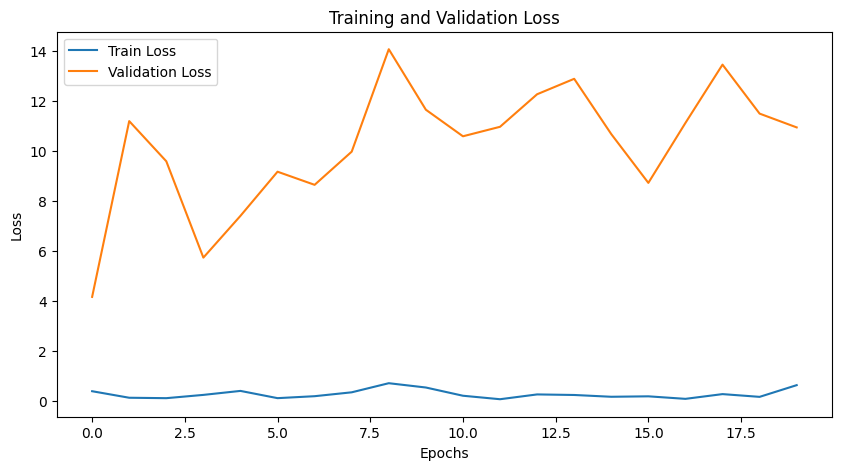

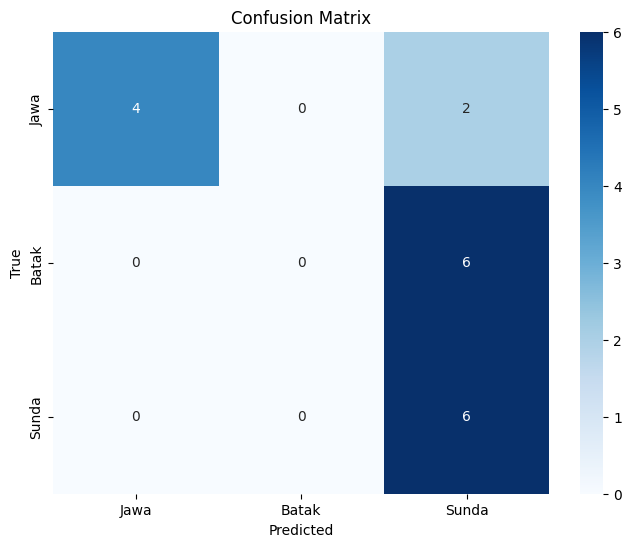

In [98]:
# Train the model
model, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)

# Plot Loss
plot_loss(train_losses, val_losses)

# Evaluate Confusion Matrix
plot_confusion_matrix(model, test_loader)


In [99]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'all_labels' is not defined